=== ANÁLISIS DE COEFICIENTES DE VARIACIÓN EN COMPRAS PÚBLICAS ===
Descargando datos de compras públicas desde GitHub...
Datos cargados: 780618 registros
Por favor, suba el archivo 'segmentos_baja_concentracion.csv':


Saving segmentos_baja_concentracion (1).csv to segmentos_baja_concentracion (1).csv
Total de segmentos: 29
Columnas disponibles: ['segmento', 'hhi1', 'hhi2', 'variacion', 'tendencia', 'flexibilidad', 'concentracion1', 'concentracion2']
Segmentos con flexibilidad Alta o Media-Alta: 21
Segmentos seleccionados: [78, 86, 30, 24, 60, 47, 51, 81, 73, 40, 39, 42, 52, 93, 11, 27, 56, 77, 53, 55, 26]
Iniciando análisis de coeficiente de variación...
Registros en segmentos flexibles: 409098 de 780618 (52.41%)
Fecha más reciente en los datos: 2024-12-31 15:57:15
Filtrando registros desde: 2023-01-11 15:57:15
Registros últimos 24 meses: 182650 de 409098 (44.65%)
Códigos con ≥3 registros: 13275
Calculando coeficientes de variación para cada código...
Analizados 1000 de 13275 códigos...
Analizados 2000 de 13275 códigos...
Analizados 3000 de 13275 códigos...
Analizados 4000 de 13275 códigos...
Analizados 5000 de 13275 códigos...
Analizados 6000 de 13275 códigos...
Analizados 7000 de 13275 códigos...


<ipython-input-1-0c20e7f8ddf4>:198: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, max(top_20['CV_ESCALADO']) * 1.1)


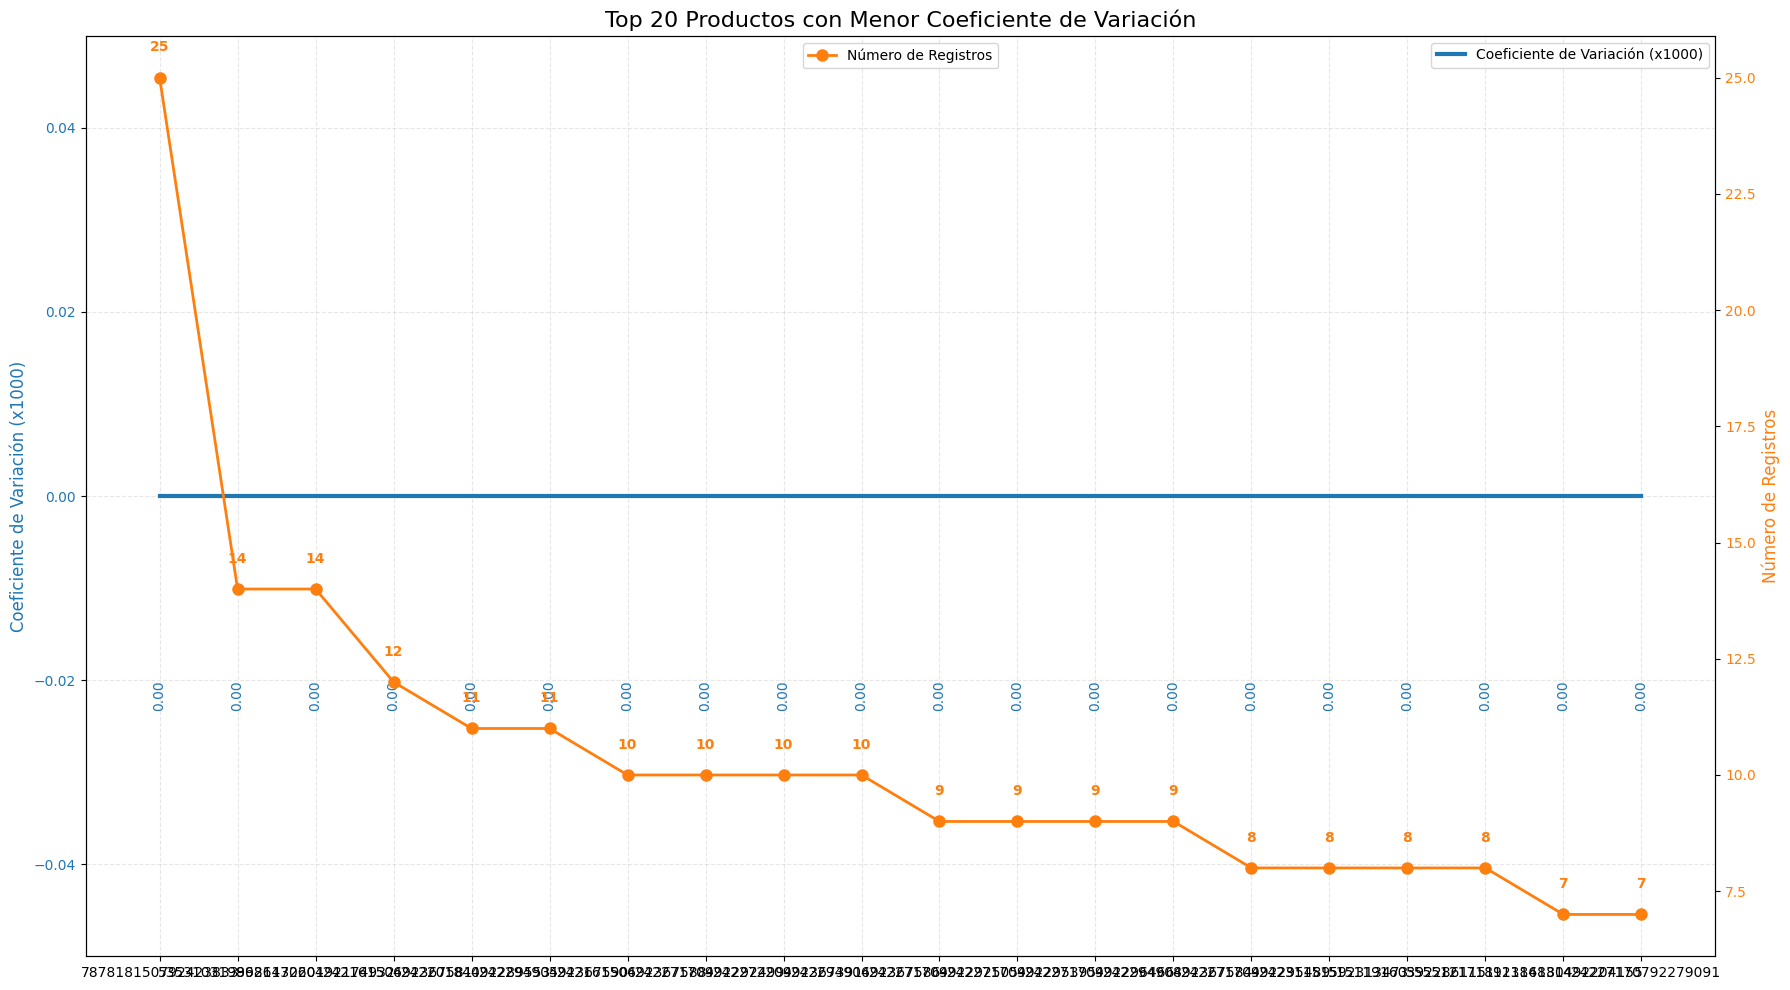

Generando gráfico de dispersión con código completo...


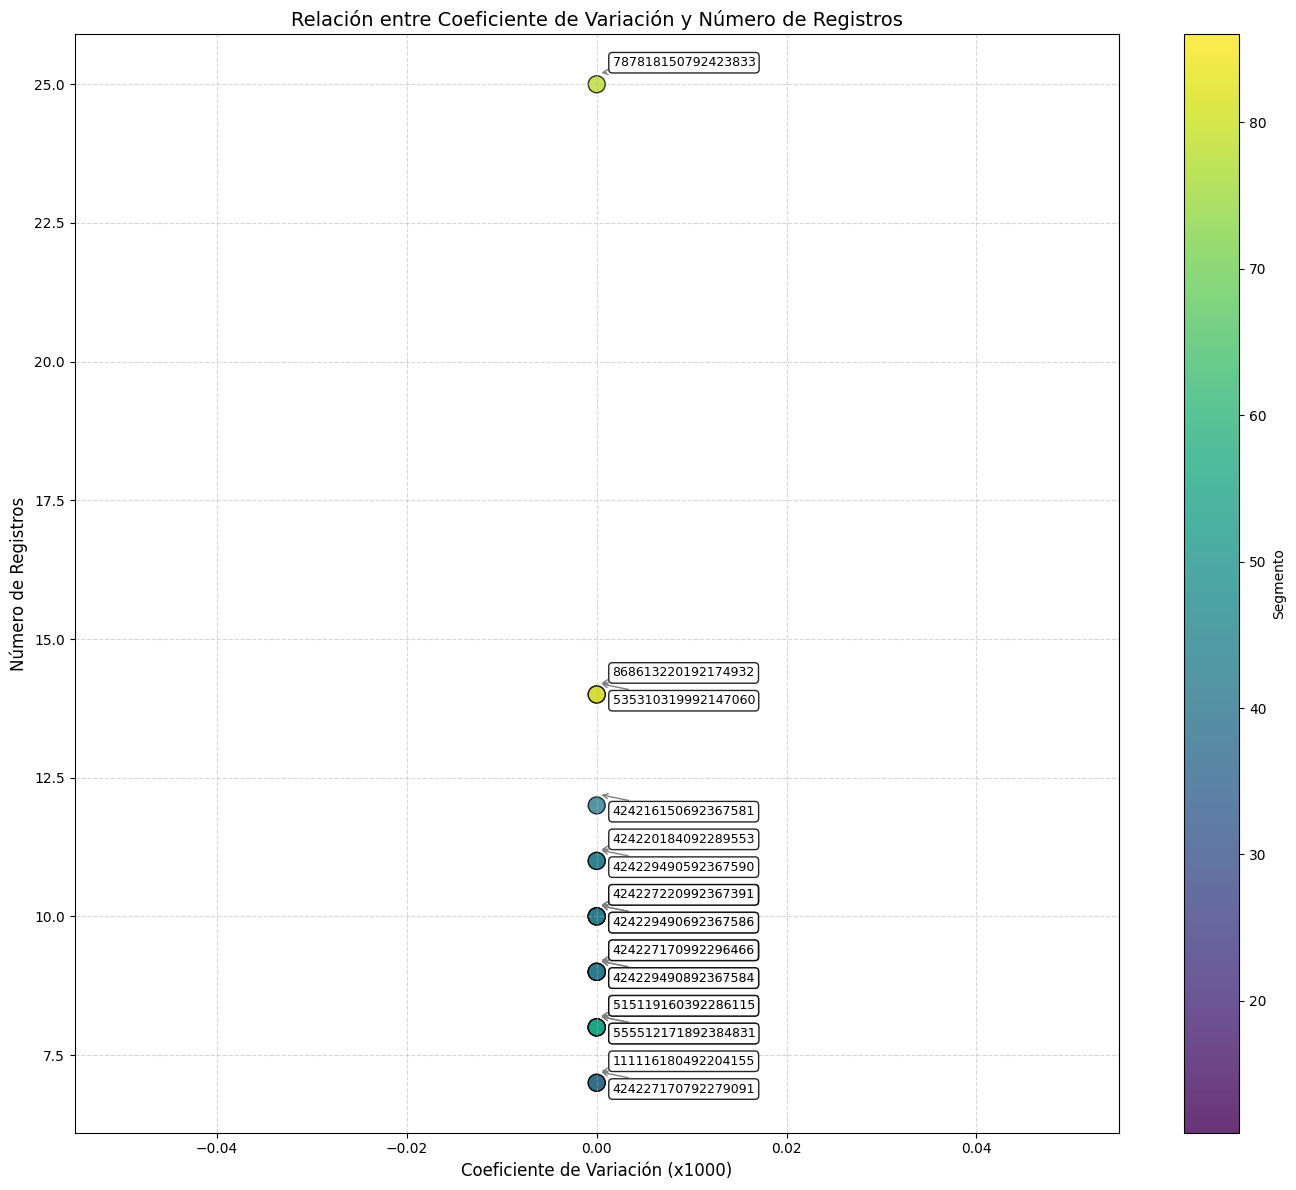

Generando tabla con los 10 productos de menor coeficiente...


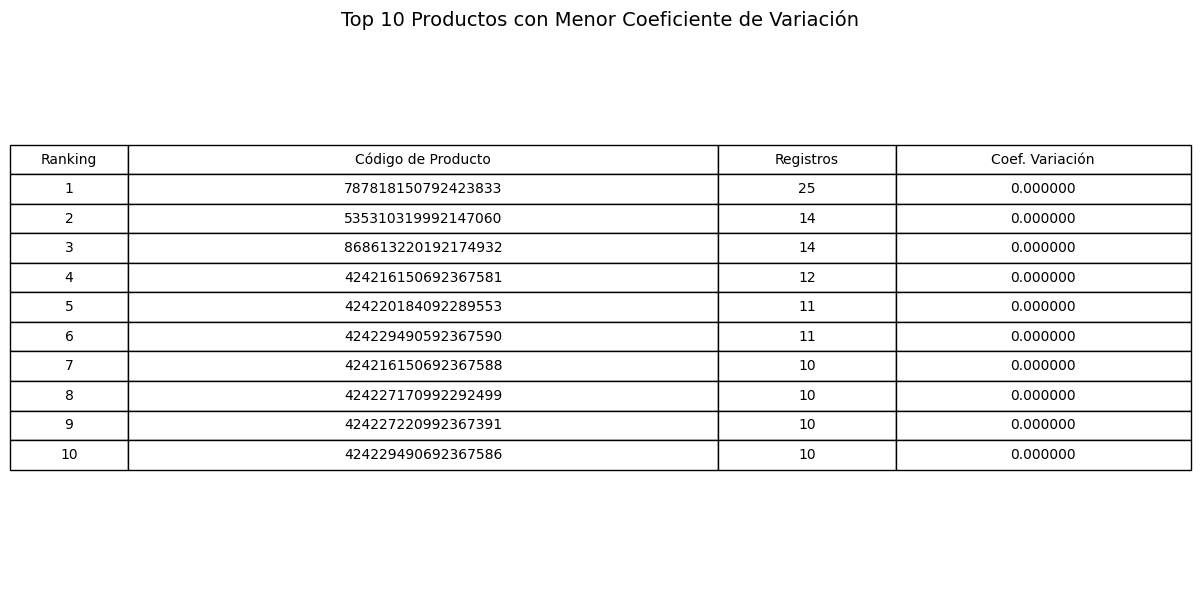

Guardado: tabla_resumen_cv.csv

=== PROCESO COMPLETADO ===
Se han generado los siguientes archivos:
1. top20_productos_vertical.png - Gráfico top 20 con códigos verticales
2. dispersion_codigo_completo.png - Gráfico de dispersión con código completo
3. tabla_top10_sin_guiones.png - Tabla con los 10 productos de menor coeficiente
4. tabla_resumen_cv.csv - CSV con todos los productos analizados


In [ ]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime, timedelta
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

def cargar_datos_github():
    print("Descargando datos de compras públicas desde GitHub...")
    url = "https://github.com/cgrcostarica/umbrales-compras-publicas/blob/main/datos/hhi2.zip?raw=true"

    try:
        response = requests.get(url)
        response.raise_for_status()

        with ZipFile(BytesIO(response.content)) as zip_file:
            csv_filename = zip_file.namelist()[0]

            with zip_file.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file)

        print(f"Datos cargados: {len(df)} registros")
        return df

    except Exception as e:
        print(f"Error: {str(e)}")
        print("Por favor, suba el archivo manualmente:")
        uploaded = files.upload()
        archivo_compras = list(uploaded.keys())[0]
        df = pd.read_csv(archivo_compras)
        return df

def cargar_segmentos():
    print("Por favor, suba el archivo 'segmentos_baja_concentracion.csv':")
    uploaded = files.upload()
    archivo_segmentos = list(uploaded.keys())[0]
    return archivo_segmentos

def obtener_segmentos_flexibles(archivo_segmentos):
    df_segmentos = pd.read_csv(archivo_segmentos)

    print(f"Total de segmentos: {len(df_segmentos)}")
    print(f"Columnas disponibles: {df_segmentos.columns.tolist()}")

    segmentos_flex = df_segmentos[df_segmentos['flexibilidad'].isin(['Alta', 'Media-Alta'])]['segmento'].tolist()

    print(f"Segmentos con flexibilidad Alta o Media-Alta: {len(segmentos_flex)}")
    print(f"Segmentos seleccionados: {segmentos_flex}")

    return segmentos_flex, df_segmentos

def calcular_coeficiente_variacion(df, segmentos_flexibles):
    print("Iniciando análisis de coeficiente de variación...")

    columnas_requeridas = ['CODIGO_PRODUCTO', 'FECHA_REGISTRO', 'PRECIO_UNITARIO_ADJUDICADO']
    for col in columnas_requeridas:
        if col not in df.columns:
            raise ValueError(f"La columna '{col}' no existe en los datos")

    df['FECHA_REGISTRO'] = pd.to_datetime(df['FECHA_REGISTRO'])
    df['CODIGO_16'] = df['CODIGO_PRODUCTO'].astype(str).str[:16]
    df['SEGMENTO'] = df['CODIGO_PRODUCTO'].astype(str).str[:2].astype(int)

    df_filtrado_segmentos = df[df['SEGMENTO'].isin(segmentos_flexibles)]
    print(f"Registros en segmentos flexibles: {len(df_filtrado_segmentos)} de {len(df)} ({len(df_filtrado_segmentos)/len(df)*100:.2f}%)")

    if len(df_filtrado_segmentos) == 0:
        raise ValueError("No se encontraron registros en los segmentos seleccionados")

    fecha_max = df_filtrado_segmentos['FECHA_REGISTRO'].max()
    print(f"Fecha más reciente en los datos: {fecha_max}")

    fecha_limite = fecha_max - pd.Timedelta(days=24*30)
    print(f"Filtrando registros desde: {fecha_limite}")

    df_filtrado_tiempo = df_filtrado_segmentos[df_filtrado_segmentos['FECHA_REGISTRO'] >= fecha_limite]
    print(f"Registros últimos 24 meses: {len(df_filtrado_tiempo)} de {len(df_filtrado_segmentos)} ({len(df_filtrado_tiempo)/len(df_filtrado_segmentos)*100:.2f}%)")

    conteo_codigos = df_filtrado_tiempo.groupby('CODIGO_16').size()
    codigos_validos = conteo_codigos[conteo_codigos >= 3].index.tolist()
    print(f"Códigos con ≥3 registros: {len(codigos_validos)}")

    df_analisis = df_filtrado_tiempo[df_filtrado_tiempo['CODIGO_16'].isin(codigos_validos)]

    resultados = []
    codigos_analizados = 0

    print("Calculando coeficientes de variación para cada código...")
    for codigo in codigos_validos:
        datos_codigo = df_analisis[df_analisis['CODIGO_16'] == codigo]
        precios = datos_codigo['PRECIO_UNITARIO_ADJUDICADO']

        media = precios.mean()
        desv_std = precios.std()

        if media > 0:
            cv = (desv_std / media) * 100
        else:
            cv = np.nan

        fecha_min = datos_codigo['FECHA_REGISTRO'].min()
        fecha_max = datos_codigo['FECHA_REGISTRO'].max()
        num_registros = len(precios)
        segmento = datos_codigo['SEGMENTO'].iloc[0]

        resultados.append({
            'SEGMENTO': segmento,
            'CODIGO_16': codigo,
            'CODIGO_COMPLETO': datos_codigo['CODIGO_PRODUCTO'].iloc[0],
            'NUM_REGISTROS': num_registros,
            'PRECIO_MEDIO': media,
            'DESVIACION_ESTANDAR': desv_std,
            'COEFICIENTE_VARIACION': cv,
            'FECHA_PRIMER_REGISTRO': fecha_min,
            'FECHA_ULTIMO_REGISTRO': fecha_max
        })

        codigos_analizados += 1
        if codigos_analizados % 1000 == 0:
            print(f"Analizados {codigos_analizados} de {len(codigos_validos)} códigos...")

    print(f"Análisis completado: {len(resultados)} códigos analizados")

    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(['COEFICIENTE_VARIACION', 'NUM_REGISTROS'], ascending=[True, False])

    print(f"Coeficiente mínimo: {df_resultados['COEFICIENTE_VARIACION'].min()}")
    print(f"Coeficiente máximo: {df_resultados['COEFICIENTE_VARIACION'].max()}")
    print(f"Número máximo de registros: {df_resultados['NUM_REGISTROS'].max()}")

    return df_resultados

def generar_grafico_top20_vertical(df_resultados):
    """
    Genera un gráfico para los 20 primeros productos con códigos verticales
    """
    print("Generando gráfico de los 20 productos con menor coeficiente...")

    # Tomar los primeros 20 productos
    top_20 = df_resultados.head(20).copy()

    # Escalar coeficientes si son muy pequeños
    max_cv = top_20['COEFICIENTE_VARIACION'].max()
    if max_cv < 1:
        factor = 1000
        top_20['CV_ESCALADO'] = top_20['COEFICIENTE_VARIACION'] * factor
        titulo_cv = f'Coeficiente de Variación (x{factor})'
    else:
        top_20['CV_ESCALADO'] = top_20['COEFICIENTE_VARIACION']
        titulo_cv = 'Coeficiente de Variación (%)'

    # Crear códigos sin guiones
    top_20['CODIGO_SIN_GUIONES'] = top_20['SEGMENTO'].astype(str) + top_20['CODIGO_16']

    # Configurar figura
    plt.figure(figsize=(18, 10))

    # Configurar aspecto del gráfico
    plt.grid(True, linestyle='--', alpha=0.3)

    # Configurar colores
    color_cv = '#1f77b4'  # Azul para coeficientes
    color_reg = '#ff7f0e'  # Naranja para registros

    # Crear eje para coeficientes
    ax1 = plt.gca()
    ax1.set_ylabel(titulo_cv, fontsize=12, color=color_cv)
    ax1.tick_params(axis='y', labelcolor=color_cv)

    # Mostrar línea para coeficientes
    x = range(len(top_20))
    ax1.plot(x, top_20['CV_ESCALADO'], color=color_cv, linewidth=3, label=titulo_cv)

    # Añadir etiquetas de coeficientes en la parte inferior
    for i, (idx, row) in enumerate(top_20.iterrows()):
        ax1.text(i, -0.02, f"{row['CV_ESCALADO']:.2f}",
                ha='center', va='top', color=color_cv, fontsize=10, rotation=90)

    # Crear segundo eje para registros
    ax2 = ax1.twinx()
    ax2.set_ylabel('Número de Registros', fontsize=12, color=color_reg,rotation=90)
    ax2.tick_params(axis='y', labelcolor=color_reg)

    # Graficar número de registros como línea con puntos
    ax2.plot(x, top_20['NUM_REGISTROS'], 'o-', color=color_reg, linewidth=2, markersize=8, label='Número de Registros')

    # Añadir etiquetas de registros
    for i, v in enumerate(top_20['NUM_REGISTROS']):
        ax2.text(i, v + 0.5, str(int(v)), ha='center', va='bottom', color=color_reg, fontweight='bold', fontsize=10)

    # Configurar eje X con etiquetas verticales
    plt.xticks(x, top_20['CODIGO_SIN_GUIONES'], rotation=90, fontsize=9)

    # Configurar límites del eje Y para coeficientes
    ax1.set_ylim(0, max(top_20['CV_ESCALADO']) * 1.1)

    # Título del gráfico
    plt.title('Top 20 Productos con Menor Coeficiente de Variación', fontsize=16)

    # Crear leyenda
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper center')

    # Ajustar espacio inferior para etiquetas verticales
    plt.subplots_adjust(bottom=0.25)

    # Guardar gráfico
    plt.tight_layout()
    plt.savefig('top20_productos_vertical.png', dpi=300, bbox_inches='tight')
    plt.show()

def generar_grafico_dispersion_con_codigo_completo(df_resultados, num_registros=20):
    """
    Genera un gráfico de dispersión mejorado con el código completo de los productos
    """
    print("Generando gráfico de dispersión con código completo...")

    # Tomar los primeros n registros (para mejor visualización)
    n = min(num_registros, len(df_resultados))
    top_n = df_resultados.head(n).copy()

    # Escalar coeficientes si son muy pequeños
    max_cv = top_n['COEFICIENTE_VARIACION'].max()
    if max_cv < 1:
        factor = 1000
        top_n['CV_ESCALADO'] = top_n['COEFICIENTE_VARIACION'] * factor
        titulo_cv = f'Coeficiente de Variación (x{factor})'
    else:
        top_n['CV_ESCALADO'] = top_n['COEFICIENTE_VARIACION']
        titulo_cv = 'Coeficiente de Variación (%)'

    # Crear código sin guiones para etiquetas
    top_n['CODIGO_SIN_GUIONES'] = top_n['SEGMENTO'].astype(str) + top_n['CODIGO_16']

    # Configurar figura
    plt.figure(figsize=(14, 12))

    # Configurar aspecto
    plt.grid(True, linestyle='--', alpha=0.5)

    # Crear gráfico de dispersión
    scatter = plt.scatter(
        top_n['CV_ESCALADO'],
        top_n['NUM_REGISTROS'],
        c=top_n['SEGMENTO'],
        cmap='viridis',
        s=150,  # Aumentar tamaño de los puntos
        alpha=0.8,
        edgecolor='black',
        linewidth=1
    )

    # Añadir etiquetas con código completo para cada punto
    for i, (idx, row) in enumerate(top_n.iterrows()):
        # Código completo para la etiqueta
        codigo = row['CODIGO_SIN_GUIONES']

        # Calcular posición para la etiqueta
        # Ajustar para colocarlas sin superposición
        offset_x = 0.0002
        offset_y = 0.2

        # Posición y offset
        if i % 2 == 0:  # Alternar para mayor legibilidad
            xytext = (10, 5)
        else:
            xytext = (10, -15)

        plt.annotate(
            codigo,
            (row['CV_ESCALADO'] + offset_x, row['NUM_REGISTROS'] + offset_y),
            xytext=xytext,
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='gray')
        )

    # Añadir títulos y etiquetas
    plt.title('Relación entre Coeficiente de Variación y Número de Registros', fontsize=14)
    plt.xlabel(titulo_cv, fontsize=12)
    plt.ylabel('Número de Registros', fontsize=12)

    # Añadir barra de colores para segmentos
    cbar = plt.colorbar(scatter)
    cbar.set_label('Segmento', fontsize=10)

    # Guardar gráfico
    plt.tight_layout()
    plt.savefig('dispersion_codigo_completo.png', dpi=300, bbox_inches='tight')
    plt.show()

def generar_tabla_top10(df_resultados):
    """
    Genera una tabla visual con los 10 productos de menor coeficiente
    """
    print("Generando tabla con los 10 productos de menor coeficiente...")

    # Tomar los 10 primeros productos
    top_10 = df_resultados.head(10).copy()

    # Preparar datos para la tabla
    tabla_data = []
    for i, (idx, row) in enumerate(top_10.iterrows()):
        # Combinar segmento y código sin guiones
        codigo_completo = f"{row['SEGMENTO']}{row['CODIGO_16']}"

        tabla_data.append([
            i+1,  # Ranking
            codigo_completo,
            row['NUM_REGISTROS'],
            f"{row['COEFICIENTE_VARIACION']:.6f}"
        ])

    # Crear figura para la tabla
    plt.figure(figsize=(12, 6))

    # Crear tabla
    tabla = plt.table(
        cellText=tabla_data,
        colLabels=['Ranking', 'Código de Producto', 'Registros', 'Coef. Variación'],
        loc='center',
        cellLoc='center',
        colWidths=[0.1, 0.5, 0.15, 0.25]
    )

    # Configurar aspecto de la tabla
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(10)
    tabla.scale(1.2, 1.5)

    # Configurar títulos
    plt.axis('off')
    plt.title('Top 10 Productos con Menor Coeficiente de Variación', fontsize=14)

    # Guardar tabla
    plt.tight_layout()
    plt.savefig('tabla_top10_sin_guiones.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    print("=== ANÁLISIS DE COEFICIENTES DE VARIACIÓN EN COMPRAS PÚBLICAS ===")

    # Cargar datos
    df_compras = cargar_datos_github()

    # Cargar segmentos
    archivo_segmentos = cargar_segmentos()

    # Obtener segmentos flexibles
    segmentos_flexibles, df_segmentos_completo = obtener_segmentos_flexibles(archivo_segmentos)

    # Calcular coeficientes de variación
    resultados = calcular_coeficiente_variacion(df_compras, segmentos_flexibles)

    # Generar gráfico top 20 con códigos verticales
    generar_grafico_top20_vertical(resultados)

    # Generar gráfico de dispersión con código completo
    generar_grafico_dispersion_con_codigo_completo(resultados, 20)

    # Generar tabla con los 10 primeros productos
    generar_tabla_top10(resultados)

    # Guardar tabla de resultados
    tabla_resumen = resultados[['SEGMENTO', 'CODIGO_16', 'CODIGO_COMPLETO', 'NUM_REGISTROS', 'COEFICIENTE_VARIACION']]
    tabla_resumen.to_csv('tabla_resumen_cv.csv', index=False)
    print("Guardado: tabla_resumen_cv.csv")

    print("\n=== PROCESO COMPLETADO ===")
    print("Se han generado los siguientes archivos:")
    print("1. top20_productos_vertical.png - Gráfico top 20 con códigos verticales")
    print("2. dispersion_codigo_completo.png - Gráfico de dispersión con código completo")
    print("3. tabla_top10_sin_guiones.png - Tabla con los 10 productos de menor coeficiente")
    print("4. tabla_resumen_cv.csv - CSV con todos los productos analizados")

if __name__ == "__main__":
    main()